We saw some differences betweent results reported in [Beissinger](https://www.nature.com/articles/nplants201684) and our paper. Was it differences in the data or methods? 

Beissinger related pi in a window to distance from nearest gene (in cM). Going to redo that appraoch on our data here to see if we find similar or different patterns.  

In [1]:
library(GenomicRanges)
library(tidyverse)
library(cowplot)
library(Rcpp)
library(purrr)
library(tidyr)
theme_set(cowplot::theme_cowplot())
library(patchwork)
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)


##Pasting the useful functions and data from BGSmodeling here

#Reading in our PI Data
read_angsd_pi = function(pi_file, stat, minimum_sites = 0.01){
    stat <- enquo(stat)
  vroom::vroom(
    pi_file, skip = 1,
    col_names = c("info", "chr", "WinCenter", "tW","tP","tF","tH","tL","Tajima","fuf","fud","fayh","zeng","nSites")) %>%
    separate(info, sep = "[\\)\\(,]", into = c(letters[1:7], "WinStart", "WinStop", "g2")) %>% 
    dplyr::select(-c(letters[1:7], g2)) %>%
    mutate(start = as.numeric(WinStart), 
           end = as.numeric(WinStop),
           size = end - start) %>% 
    na.omit() %>% 
    mutate(pi = !! stat / nSites) %>% #!!! changed from tP!!!
    filter(pi > 0, nSites > minimum_sites*size) %>%
    dplyr::select(chr, start, end, pi)     
}

#!!!REQUIRES ALL INPUT DFS INCLUDE COLUMN NAMES: chr, start, end
CM <- function(genetic_df, pi_df){
  tibble(
  cm_start = approx(x = genetic_df$pos, y = genetic_df$cm, xout = pi_df$start)$y,
  cm_end = approx(x = genetic_df$pos, y = genetic_df$cm, xout = pi_df$end)$y,
  cm_mid = (cm_start + cm_end)/2,
  cm_mb = approx(x = genetic_df$pos, y = genetic_df$cm_mb, xout = (pi_df$start + pi_df$end)/2)$y,
  rec = cm_end - cm_start
  )
}

pi_files <- list.files(path = "../data/angsd_pi", pattern = "chr10--0--152435371.1000BP_theta.thetasWindow.gz.pestPG", full.names = TRUE)
pops <- str_replace(pi_files, "../data/angsd_pi/(..*)_theta.txt", "\\1")

#file_df <- separate(tibble(file = pi_files, x = pi_files), x, sep = "--|\\.", into = c("a", "b", "path", "ssp", "pop", "chrom", "start", "end", "bp", "j", "k", "l")) %>% 
#mutate(ssp_pop = str_glue("{ssp}_{pop}"),
#      ssp_pop_bp = str_glue("{ssp}_{pop}_{bp}"))

gen_map_all_chr <- read_delim("../data/map/ogut_v5.map.txt", delim = "\t") %>% 
  drop_na() %>%
  mutate(cm = cm + abs(min(cm))) %>%
  group_by(chr) %>% 
  group_modify(~{
    df1 <- slice(.x, -nrow(.x))
    df2 <- slice(.x, -1)
    to_keep <- df2$cm > df1$cm & df2$pos > df1$pos
    df1 <- df1[to_keep, ]
    df2 <- df2[to_keep, ]
    cm_mb <- tibble(cm_mb = 1e6*(df2$cm - df1$cm)/(df2$pos - df1$pos))
    bind_cols(df2, cm_mb)
  }) %>% 
  mutate(chr = paste0("chr", chr))

#made with 
#zcat < data/refs/v5/v5.gff3.gz | grep "P001" | bedtools sort -i stdin | bedtools merge -i stdin > data/refs/v5_functional.bed
gff_test <- vroom::vroom(
  "../data/refs/v5_functional.bed", 
  delim = "\t",
  comment = "#", 
  col_names = c("chr", "start", "end")
  )

chrms <- paste0("chr", 1:10)

head(gff_test); head(gen_map_all_chr)


theta_df <- read_csv("linkedsel_predDF.csv")  %>% 
    rename(ssp_pop = pop) %>% 
    filter(model == "full", param == "theta") %>% 
    select(ssp_pop, value) %>% 
    distinct()

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The

chr,start,end
<chr>,<dbl>,<dbl>
chr1,34616,35318
chr1,36036,36174
chr1,36258,36504
chr1,36599,36713
chr1,36821,37004
chr1,37415,37633


chr,pos,cm,cm_mb
<chr>,<dbl>,<dbl>,<dbl>
chr1,214369,3.4,2.246181
chr1,341276,3.6,1.575957
chr1,370511,3.8,6.841115
chr1,532547,4.2,2.468587
chr1,603370,4.4,2.823941
chr1,694670,4.6,2.190581



── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  chr = col_character(),
  model = col_character(),
  mode = col_character(),
  pop = col_character(),
  param = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [2]:
get_funct_dist <- function(pi_files, stat){
    
    stat <- enquo(stat)

    pi_files %>% map_df(~{

        pop <- .x %>% str_remove_all('(../data/angsd_pi/v5--|.chr10--0--152435371.1000BP_theta.thetasWindow.gz.pestPG)')
        pi_test <- read_angsd_pi(.x, stat = !!stat, minimum_sites = 0.7)

        mid <- floor((pi_test$start + pi_test$end)/2)
        pi_ranges <- GRanges(pi_test$chr, IRanges(mid, mid), pi = pi_test$pi)
        gff_ranges <- GRanges(gff_test$chr, IRanges(gff_test$start, gff_test$end))
        cloest_gff_ranges <- gff_ranges[nearest(pi_ranges, gff_ranges),]
        cds_gap_df <- data.frame(pgap(pi_ranges, cloest_gff_ranges)) %>% 
            rename(chr = seqnames)

        cm_df <- CM(gen_map_all_chr, cds_gap_df)
        cm_gap <- cm_df$cm_start - cm_df$cm_end 
        mutate(pi_test, cm = cm_gap, ssp_pop = pop) %>% drop_na(cm, pi)
    }) %>% 
        mutate(splitme = ssp_pop) %>% 
        mutate(ssp_pop = str_remove_all(ssp_pop, "-$")) %>% 
        separate(splitme, c("ssp", "pop"), "--") %>% 
        mutate(genic = ifelse(cm == 0, "genic", "non-genic")) 
    }


#pi and distance from CDS 
closestPI_cds_df <- get_funct_dist(pi_files, tP)

#singleton diversity and distance from CDS
closestSINGLETON_cds_df <- get_funct_dist(pi_files, tF)


#add modeled and simple BETA estimates  
closestPI_cds_df <- 
closestPI_cds_df %>% 
    group_by(ssp_pop) %>% 
    filter(cm > 0.01) %>% 
    summarise(big_pi = mean(pi)) %>% 
    full_join(., closestPI_cds_df, by = "ssp_pop") %>% 
    full_join(., theta_df, by = "ssp_pop") %>% 
    mutate(B = pi / big_pi, B_model = pi / value)
    
    
    
closestSINGLETON_cds_df <- 
closestSINGLETON_cds_df %>% 
    group_by(ssp_pop) %>% 
    filter(cm > 0.01) %>% 
    summarise(big_pi = mean(pi)) %>% 
    full_join(., closestSINGLETON_cds_df, by = "ssp_pop") %>% 
    full_join(., theta_df, by = "ssp_pop") %>% 
    mutate(B = pi / big_pi, B_model = pi / value)

    


Rows: 152,434
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 152,434
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 152,434
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 152,434
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column sp

Rows: 152,434
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 152,434
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 152,434
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 152,434
Columns: 14
Delimiter: "\t"
chr [ 2]: info, chr
dbl [12]: WinCenter, tW, tP, tF, tH, tL, Tajima, fuf, fud, fayh, zeng, nSites

Use `spec()` to retrieve the guessed column sp

`summarise()` has grouped output by 'genic'. You can override using the `.groups` argument.




Call:
lm(formula = pi ~ genic * ssp, data = mutate(closestPI_cds_df, 
    genic = ifelse(cm == 0, "genic", "non-genic")))

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0077867 -0.0028632 -0.0002922  0.0025053  0.0206360 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.0055847  0.0001853  30.133  < 2e-16 ***
genicnon-genic        0.0003268  0.0001856   1.760   0.0784 .  
sspTeo                0.0016198  0.0002566   6.313 2.74e-10 ***
genicnon-genic:sspTeo 0.0002554  0.0002570   0.994   0.3203    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003785 on 265507 degrees of freedom
Multiple R-squared:  0.05771,	Adjusted R-squared:  0.0577 
F-statistic:  5420 on 3 and 265507 DF,  p-value: < 2.2e-16



Call:
lm(formula = pi ~ genic * ssp, data = match_df)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0075320 -0.0028061 -0.0004659  0.0024270  0.0173574 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            5.585e-03  1.841e-04  30.329  < 2e-16 ***
genicnon-genic         2.590e-04  2.604e-04   0.994    0.320    
sspTeo                 1.710e-03  2.604e-04   6.566 6.88e-11 ***
genicnon-genic:sspTeo -1.141e-05  3.683e-04  -0.031    0.975    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.00376 on 1664 degrees of freedom
Multiple R-squared:  0.04998,	Adjusted R-squared:  0.04827 
F-statistic: 29.18 on 3 and 1664 DF,  p-value: < 2.2e-16


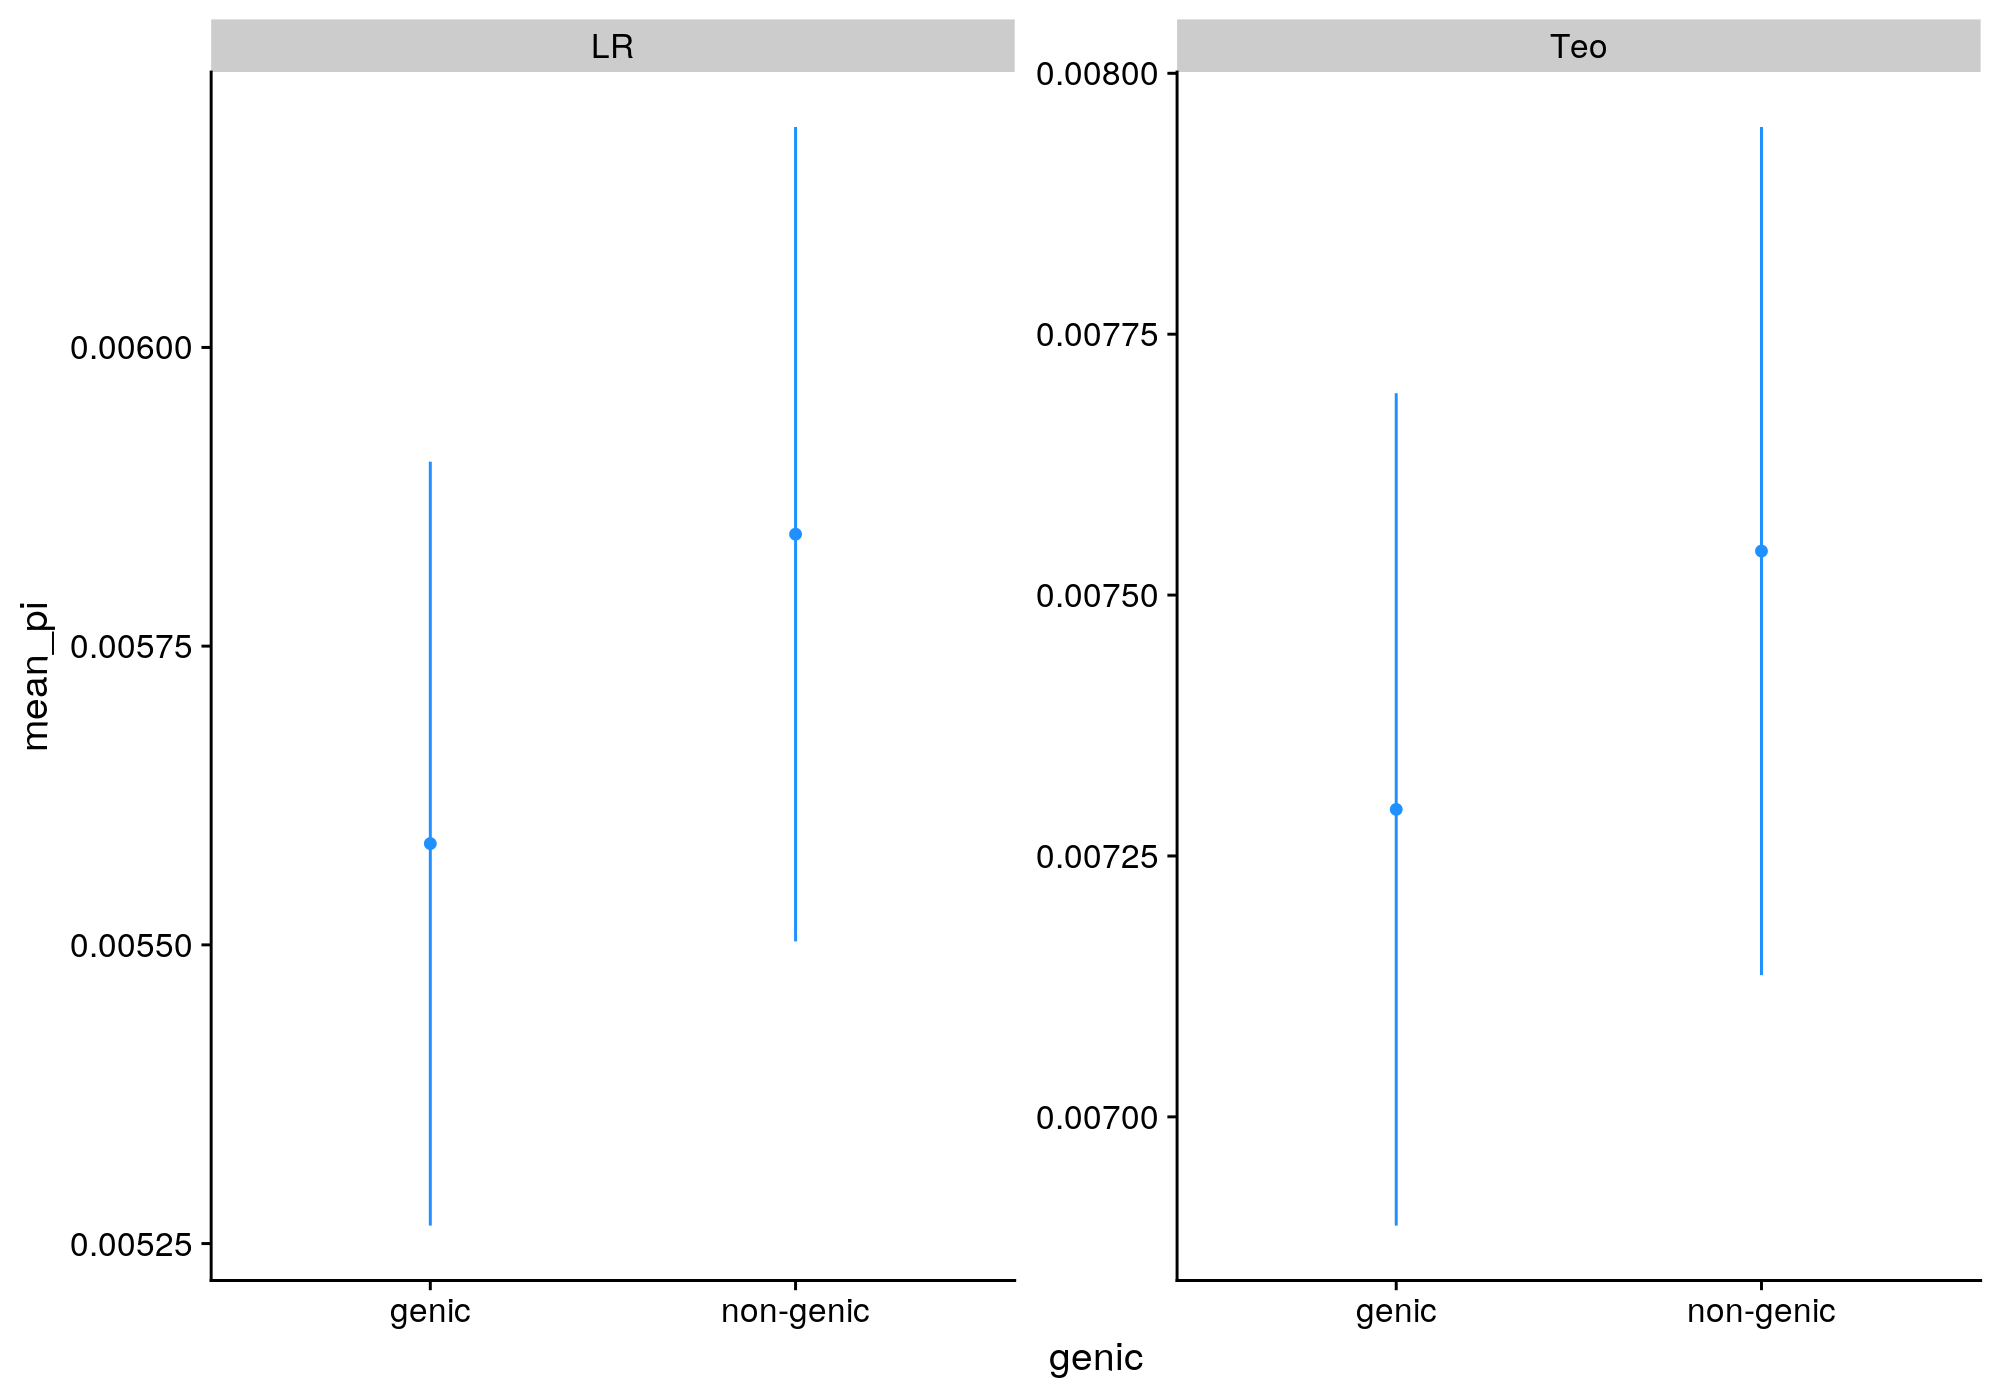

In [3]:
match_df <- 
closestPI_cds_df %>% 
    group_by(genic, ssp) %>% 
    sample_n(417)

ci_df <- 
match_df %>% 
    summarise(
        mean_pi = mean(pi), 
        low_ci = mean_pi - 2*sd(pi)/sqrt(n()),
        hi_ci = mean_pi + 2*sd(pi)/sqrt(n())
    )


summary(lm(pi ~ genic*ssp, data = mutate(closestPI_cds_df, genic = ifelse(cm == 0, "genic", "non-genic"))))
summary(lm(pi ~ genic*ssp, data = match_df))

ggplot() +
#geom_jitter(data = match_df, aes(genic, pi), shape =1) + 
geom_point(data = ci_df, aes(genic, mean_pi), colour = "dodgerblue") +
geom_segment(data = ci_df, aes(x = genic, y = low_ci, xend = genic, yend = hi_ci), colour = "dodgerblue") +
facet_wrap(~ssp, scales = "free") 

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 73046 rows containing non-finite values (stat_smooth).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 73267 rows containing non-finite values (stat_smooth).”


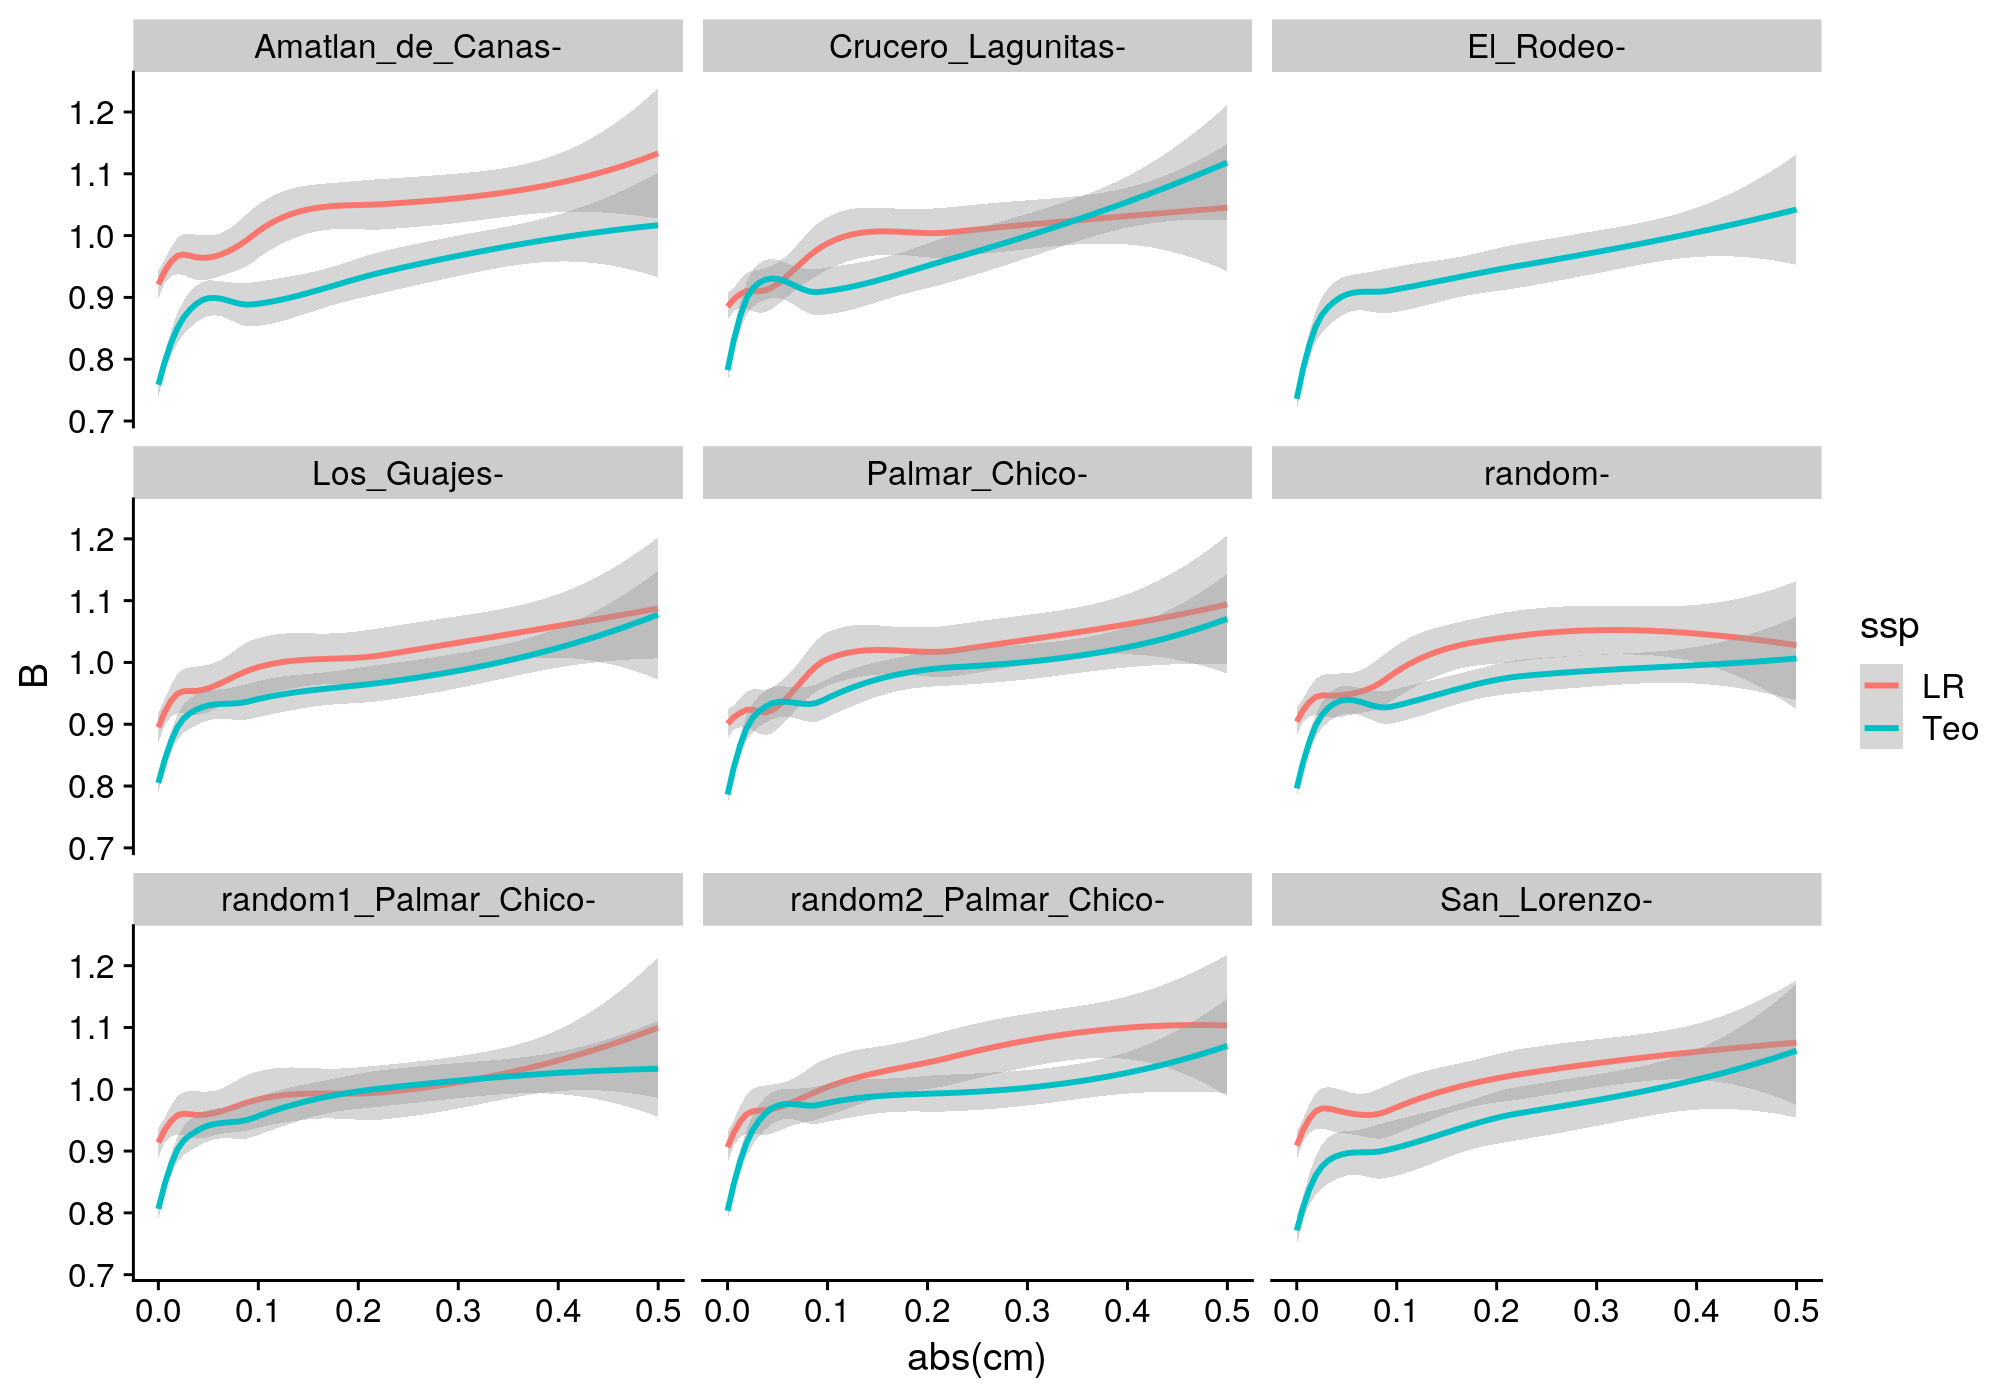

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 73135 rows containing non-finite values (stat_smooth).”


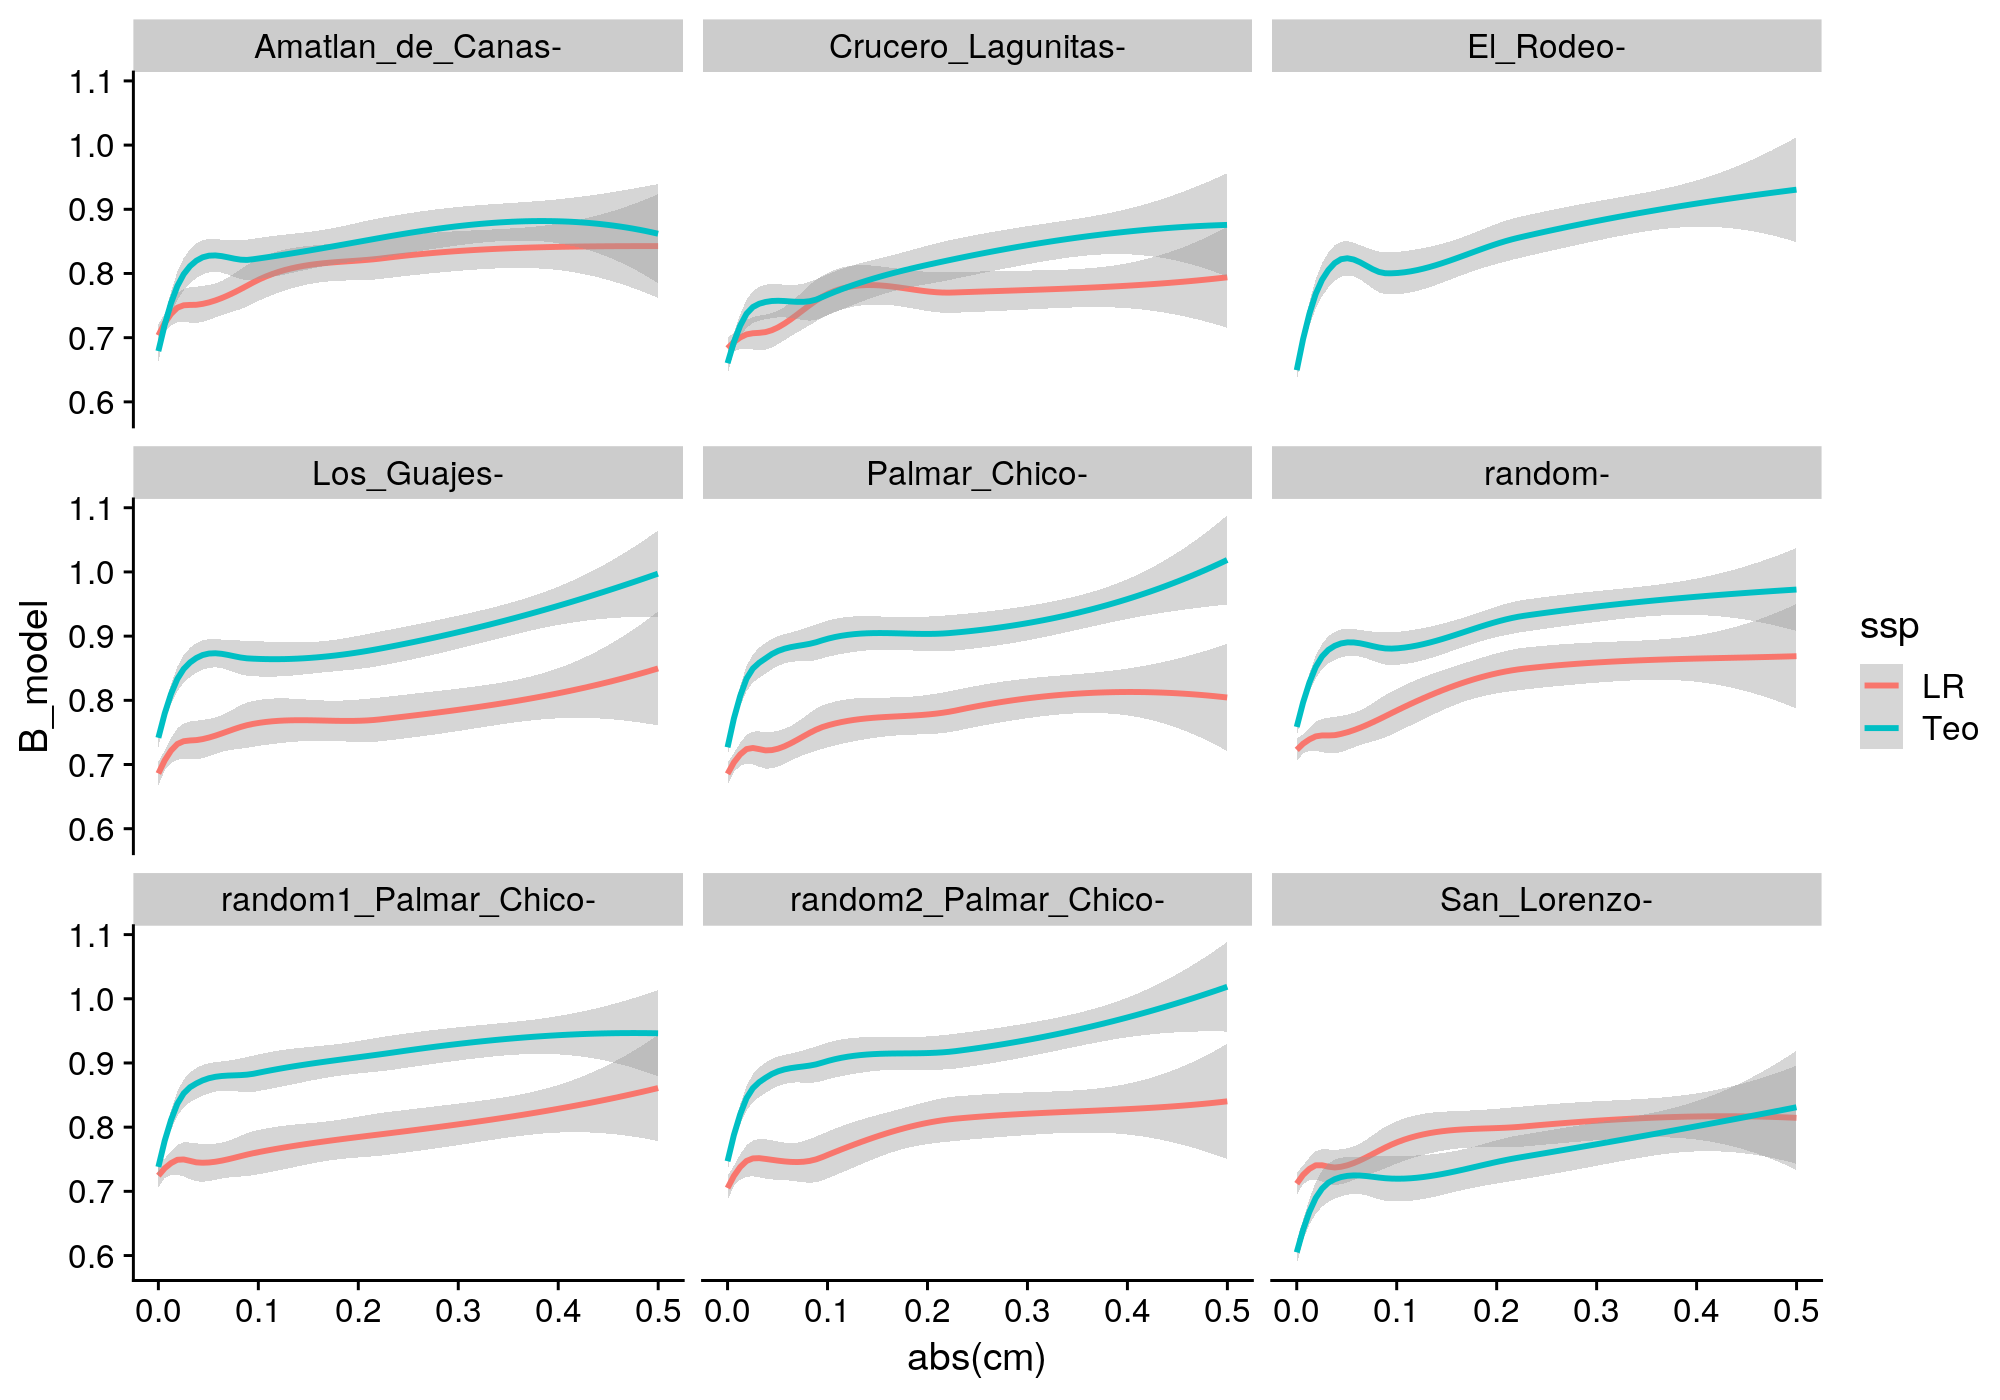

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 72921 rows containing non-finite values (stat_smooth).”


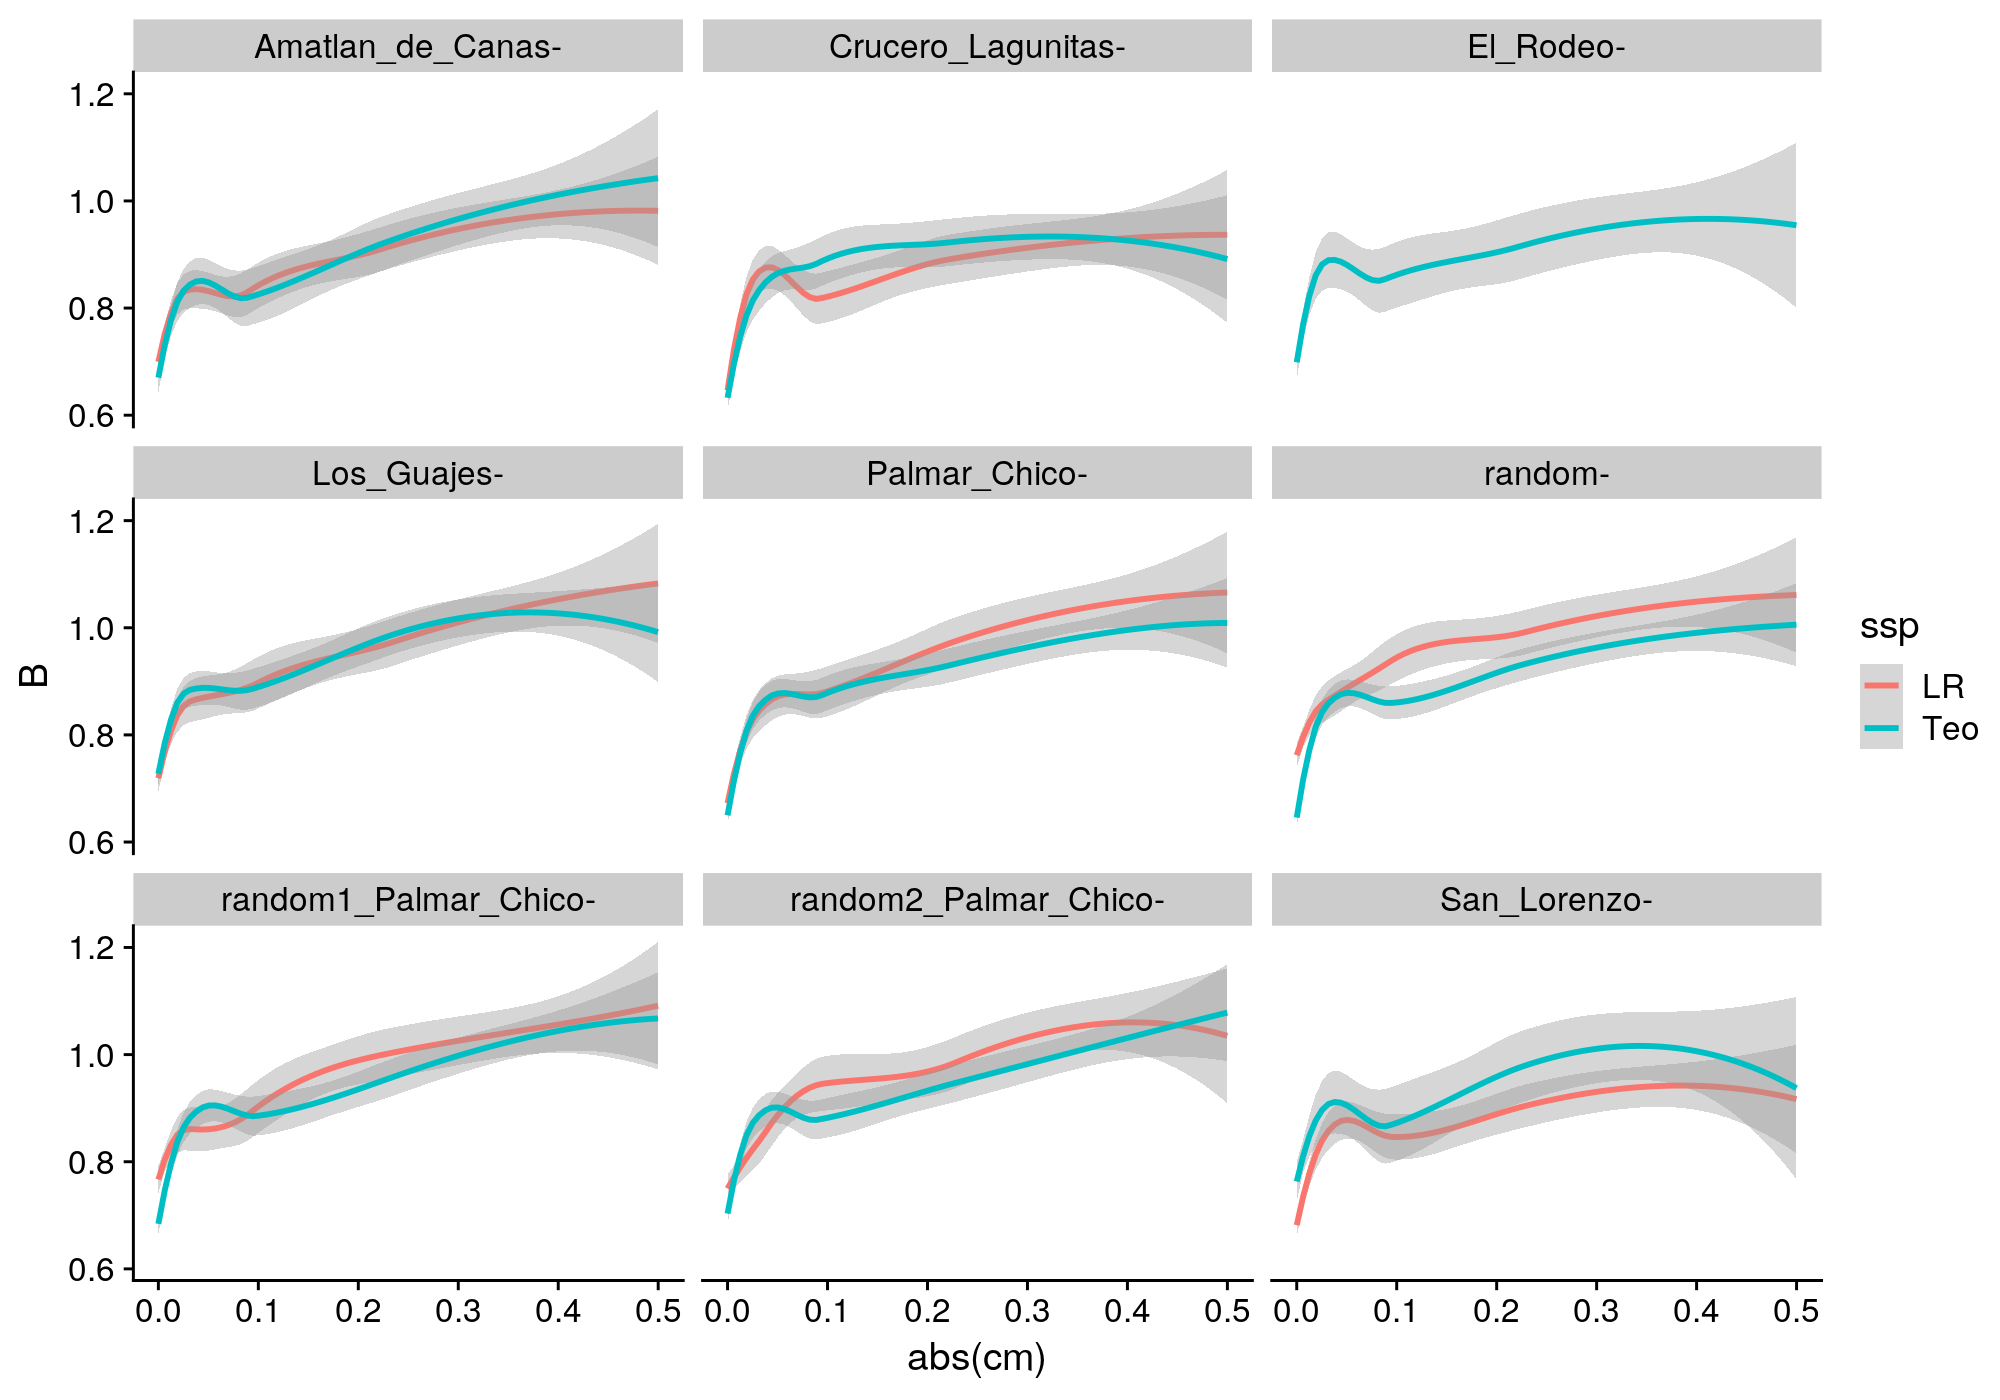

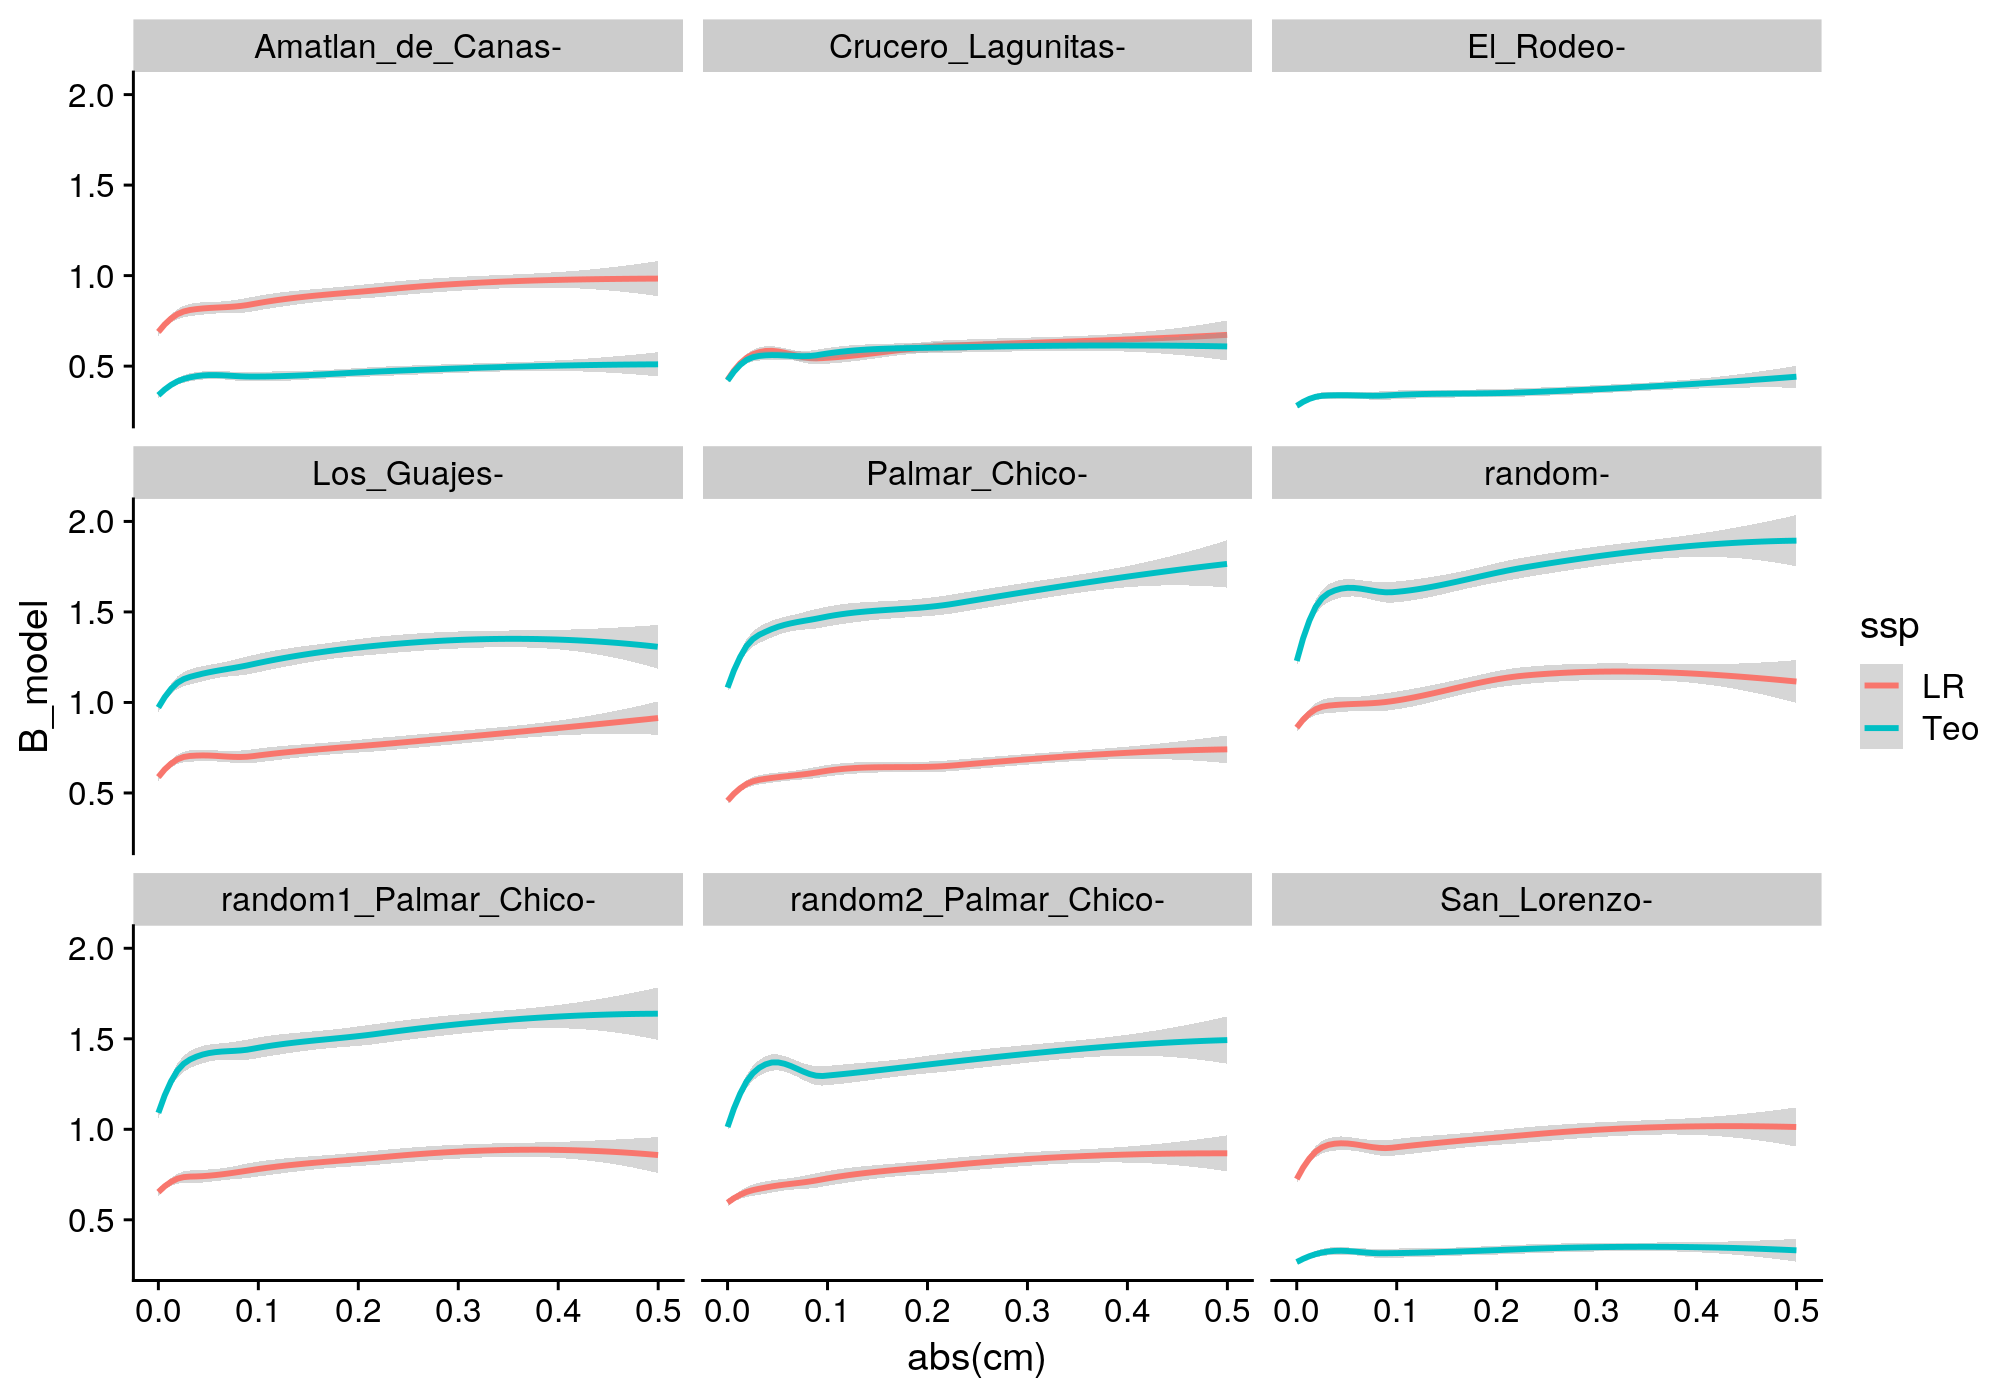

In [4]:
#TO DO: USE NEUTRAL THETA TO SET 

#SET NEUTRAL TO BE THE AVERAGE VALUE OF PI > 0.01CM AWAY

plot_cmb <- function(df, var){
    var <- enquo(var)
    df %>% 
    group_by(ssp_pop) %>% 
    sample_n(10000) %>% 
    ggplot(aes(abs(cm), !!var, colour = ssp)) +
    #geom_point(alpha = 0.1) +
    geom_smooth(method = "loess") +
    facet_wrap(~pop) +
    xlim(0, 0.5)
}

pi_b <- plot_cmb(closestPI_cds_df, B)
pi_bm <- plot_cmb(closestPI_cds_df, B_model)
   
sing_b <- plot_cmb(closestSINGLETON_cds_df, B)
sing_bm <- plot_cmb(closestSINGLETON_cds_df, B_model)
    
pi_b
pi_bm 
sing_b 
sing_bm

Saving 6.67 x 6.67 in image

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 26778 rows containing non-finite values (stat_smooth).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 26778 rows containing non-finite values (stat_smooth).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 26778 rows containing non-finite values (stat_smooth).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 26778 rows containing non-finite values (stat_smooth).”


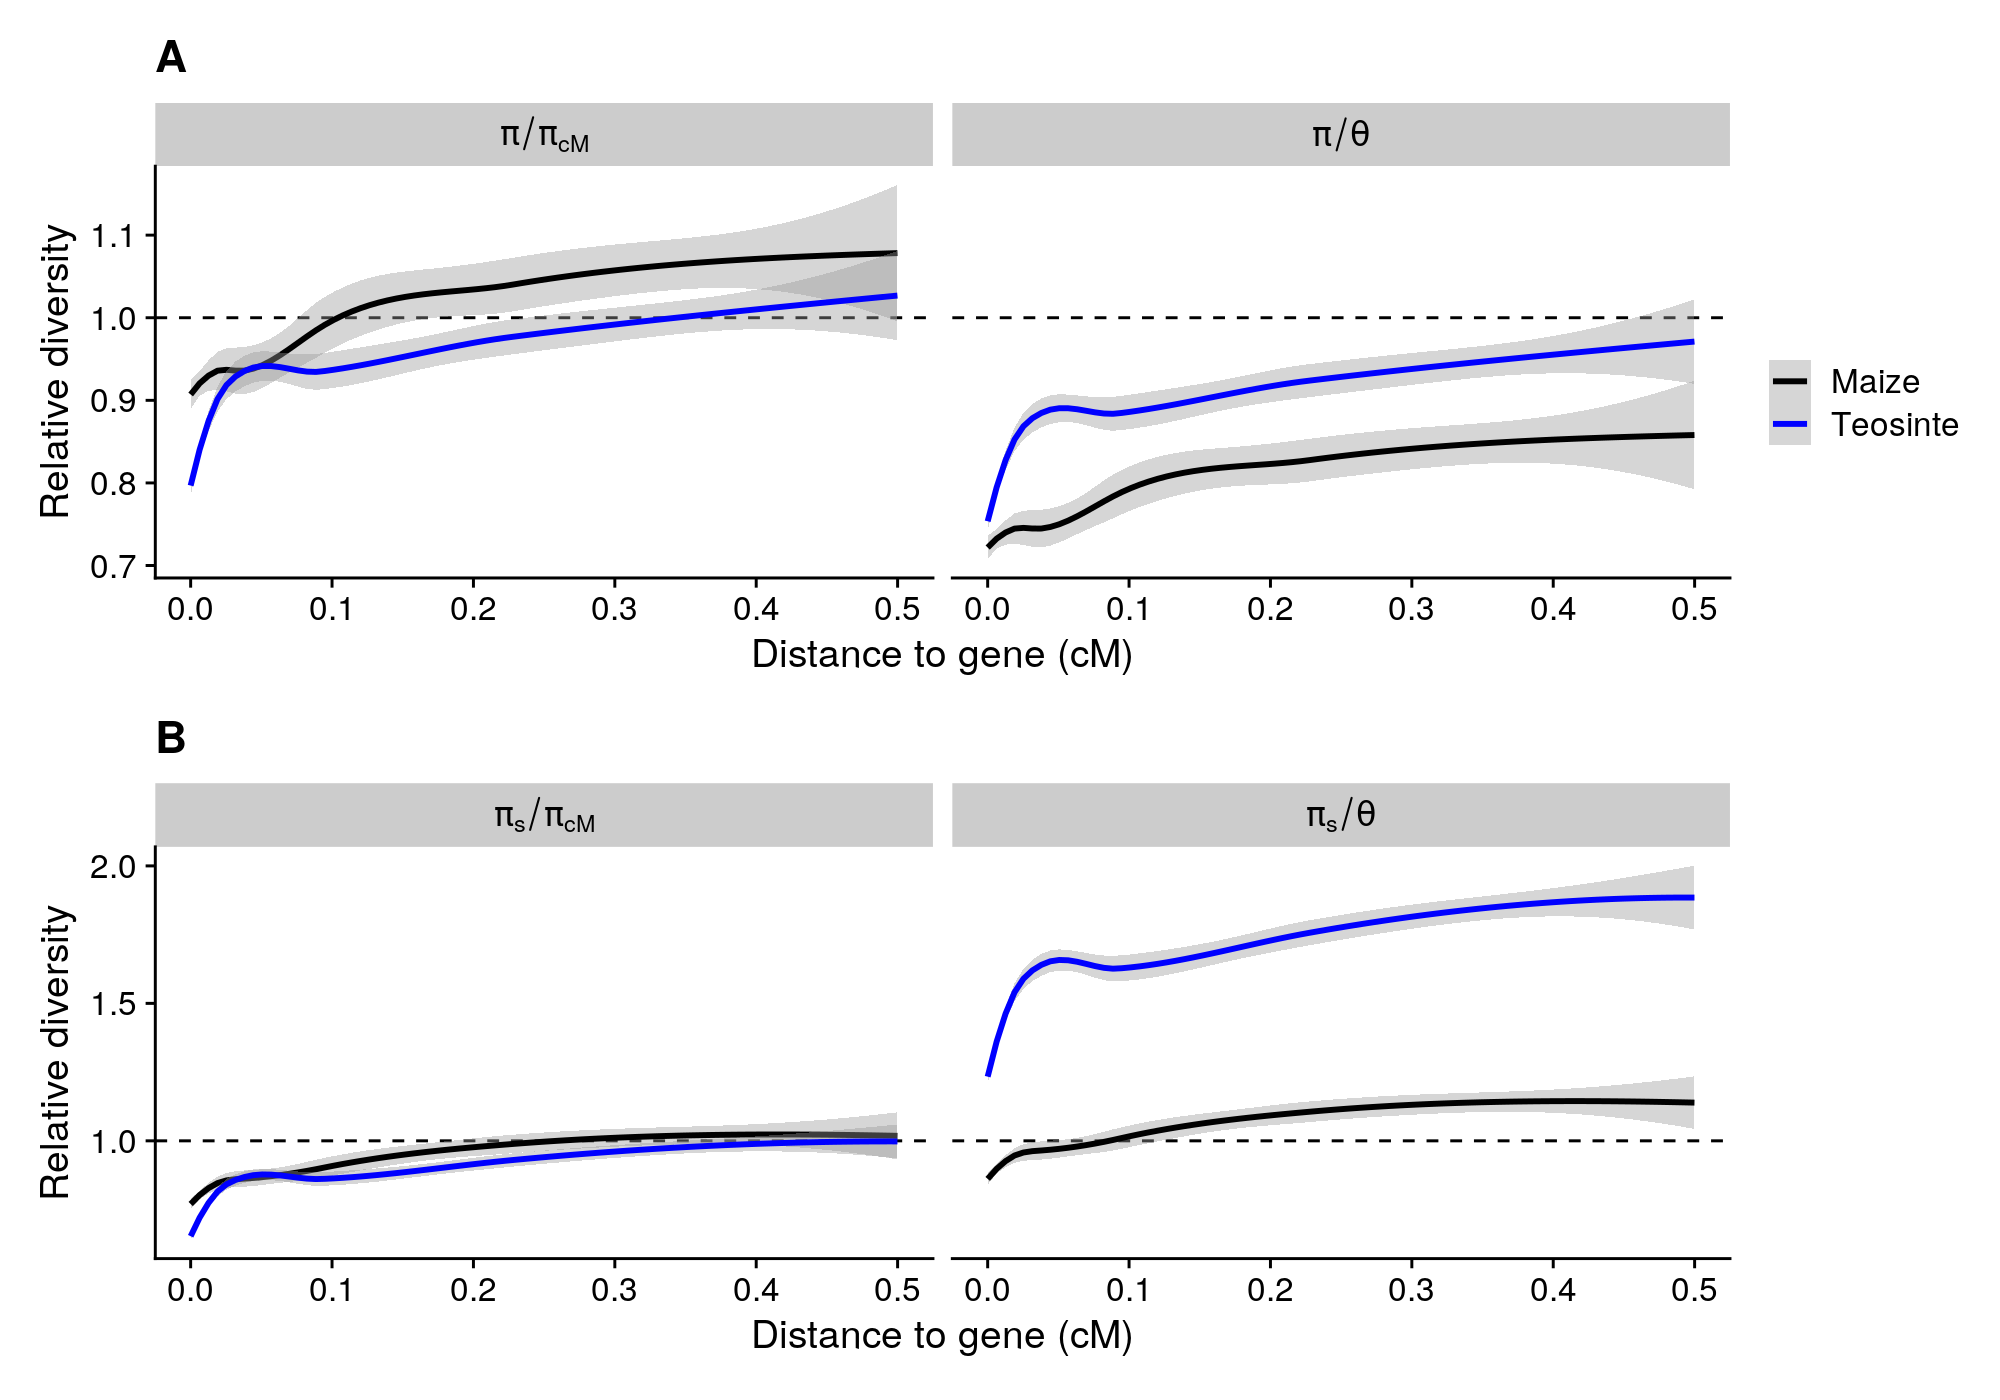

In [19]:
plot_pop_cmb <- function(df, var, pop_str, my_labels){
    var <- enquo(var)

    df_plot <- df %>% 
    filter(grepl(pop_str, pop)) %>% 
    select(cm, ssp, pop, ssp_pop, pi, value, B, B_model) %>% 
    pivot_longer(c(B, B_model), names_to ="B_type", values_to = "B_value")  %>% 
    mutate(
        ssp = ifelse(ssp == "LR", "Maize", "Teosinte"),
        B_type = ifelse(B_type == "B", my_labels[1], my_labels[2])
    )
    ggplot(data = df_plot, aes(abs(cm), B_value, colour = ssp)) +
    geom_hline(yintercept = 1, lty = 2) +
    geom_smooth(method = "loess") +
    facet_wrap(~B_type, labeller = label_parsed) +
    xlim(0, 0.5) +
    ylab("Relative diversity") +
    xlab("Distance to gene (cM)") +
    scale_color_manual(values = c("Maize" = "black", "Teosinte" = "blue")) +
    labs(colour = "") 
}


plot_pop_cmb(closestPI_cds_df, B, pop_str = "random-", c("pi/pi[cM]", "pi/theta")) +
ggtitle("A") +
plot_pop_cmb(closestSINGLETON_cds_df, B, pop_str = "random-", c("pi[s]/pi[cM]", "pi[s]/theta")) +
theme(legend.position = "n") +
ggtitle("B") +
plot_layout(nrow = 2, heights = c(1,1)) +
ggsave("../figures/supplement_BGS.pdf")
